walmart 주단위 데이터 139주로 향후 4주 예측하기

In [253]:
import tensorflow as tf
import numpy as np
import matplotlib
import os
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime  
tf.set_random_seed(77)
columns=['date','sales']
txs=pd.read_table('./lstmData/lstmPrac12.csv', sep=',',header=None,names=columns )
tf.reset_default_graph()

In [254]:
txs

,date,sales
0,2010-02-05,24924.50
1,2010-02-12,46039.49
2,2010-02-19,41595.55
3,2010-02-26,19403.54
4,2010-03-05,21827.90
5,2010-03-12,21043.39
6,2010-03-19,22136.64
7,2010-03-26,26229.21
8,2010-04-02,57258.43
9,2010-04-09,42960.91


In [255]:
def noOutlierSales(sales):
    mean=np.mean(sales)
    std=np.std(sales)
    for i in range(len(sales)):
        if (sales[i]<mean-2*std or sales[i]>mean+2*std):
             sales[i]=int(mean)
    return sales
def logSales(sales):
    for i in range(len(sales)):
        if sales[i] is 0:
            sales[i]=1
    return np.log(sales)
def sqrtSales(sales):
    return np.sqrt(sales)


def rmse(a,b):
    sum=0
    for i in range(len(a)):
        sum=sum+(a[i]-b[i])**2
    return np.sqrt(sum/len(a))

def minMaxNormalizer(data):
    numerator=data-np.min(data)
    denominator=np.max(data)-np.min(data)
    return numerator/(denominator+1e-7)

def minMaxDeNormalizer(data, originalData):
    shift=np.min(originalData)
    multiplier=np.max(originalData)-np.min(originalData)
    return (data+shift)*multiplier


In [256]:
def LSTM(txs, forecastDay, features):
    tf.set_random_seed(77)
    #Add basic date related features to the table
    year = lambda x: datetime.strptime(x, "%Y-%m-%d").year
    dayOfWeek = lambda x: datetime.strptime(x, "%Y-%m-%d").weekday()
    month = lambda x: datetime.strptime(x, "%Y-%m-%d").month
    weekNumber = lambda x: datetime.strptime(x, "%Y-%m-%d").strftime('%V')
    txs['year'] = txs['date'].map(year)
    txs['month'] = txs['date'].map(month)
    txs['weekNumber'] = txs['date'].map(weekNumber)
    txs['dayOfWeek'] = txs['date'].map(dayOfWeek)

    #Add non-basic date related features to the table
    seasons = [0, 0, 1, 1, 1, 2, 2, 2, 3, 3, 3, 0]  # dec - feb is winter, then spring, summer, fall etc
    season = lambda x: seasons[(datetime.strptime(x, "%Y-%m-%d").month - 1)]
    day_of_week01s = [0, 0, 0, 0, 0, 1, 1]
    day_of_week01 = lambda x: day_of_week01s[(datetime.strptime(x, "%Y-%m-%d").weekday())]
    txs['season'] = txs['date'].map(season)
    txs['dayOfWeek01'] = txs['date'].map(day_of_week01)

    #Backup originalSales
    originalSales = list(txs['sales'])
    sales = list(txs['sales'])

    if features is 'DayOfWeek_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]
    elif features is'DayOfWeek01_WeekNumber_Month_Season' :
        tempxy = [list(txs['dayOfWeek01']), list(txs['weekNumber']),list(txs['month']),list(txs['season']) , sales]

    elif features is 'WeekNumber_Month_Season_Year' :
        tempxy = [list(txs['weekNumber']), list(txs['month']), list(txs['season']),list(txs['year']), sales]

    xy = np.array(tempxy).transpose().astype(np.float)

    #Backup originalXY for denormalize
    originalXY = np.array(tempxy).transpose().astype(np.float)
    xy = minMaxNormalizer(xy)

    #TRAIN PARAMETERS
    # data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
    data_dim = 5
    # data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
    seq_length = 10
    # output_dim(=forecastDays)만큼의 다음날 y_data를 예측
    output_dim = forecastDay
    # hidden_dim은 정말 임의로 설정
    hidden_dim = 100
    # learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
    learning_rate = 0.001
    # iterations는 반복 횟수
    iterations = 5000

    # Build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
    x = xy
    y = xy[:, [-1]]
    dataX = []
    dataY = []
    for i in range(0, len(y) - seq_length - forecastDay+1):
        _x = x[i:i + seq_length]
        _y = y[i + seq_length:i + seq_length + forecastDay]
        _y = np.reshape(_y, (forecastDay))
        print(_x,"->",_y)
        dataX.append(_x)
        dataY.append(_y)
    print('data set length:',len(y) - seq_length - forecastDay+1)
    
    train_size = int(len(dataY) * 0.7)
    test_size = len(dataY) - train_size
    print('train size:' , train_size)
    print('test size:' , test_size)
    trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
    print('trainX:', trainX)
    print('testX:', testX)
    trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])

    X = tf.placeholder(tf.float32, [None, seq_length, data_dim])
    Y = tf.placeholder(tf.float32, [None, forecastDay])

    cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
    outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
    Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn=None)
    loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
    optimizer = tf.train.AdamOptimizer(learning_rate)
    train = optimizer.minimize(loss)
    
    denormalizedTestY=originalSales[train_size+seq_length:]
#     denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])
    
    targets = tf.placeholder(tf.float32, [None, 1])
    predictions = tf.placeholder(tf.float32, [None, 1])
 
    with tf.Session() as sess:

        # 초기화
        init = tf.global_variables_initializer()
        sess.run(init)

        # Training step
        for i in range(iterations):
            _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
            print("[step: {}] loss: {}".format(i, step_loss))
       

        # Test step
        # test_predict= sess.run(Y_pred, feed_dict={X: testX}
        test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalXY)
        realSale= minMaxDeNormalizer(testY,originalXY)
        # Plot predictions
#         plt.plot(denormalizedTestY_feed) #실제 sales 파란색
        plt.plot(realSale)      #실제 sales 파란색
        plt.plot(test_predict) #예측 sales 주황색
               
        plt.xlabel("Time Period")
        plt.ylabel("Stock Price")
        plt.show()
        
    return (test_predict), realSale




[[  8.68174327e-05   3.47269731e-05   0.00000000e+00   3.49006079e-02
    4.32776220e-01]
 [  1.04180919e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.99406065e-01]
 [  1.21544406e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    7.22243772e-01]
 [  1.38907892e-04   3.47269731e-05   0.00000000e+00   3.49006079e-02
    3.36913105e-01]
 [  1.56271379e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.79008448e-01]
 [  1.73634865e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.65386619e-01]
 [  1.90998352e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    3.84369251e-01]
 [  2.08361838e-04   5.20904596e-05   1.73634865e-05   3.49006079e-02
    4.55430535e-01]
 [  2.25725325e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    9.94205978e-01]
 [  2.43088811e-04   6.94539461e-05   1.73634865e-05   3.49006079e-02
    7.45951182e-01]] -> [ 0.30554458  0.28033957  0.28745443  0.30236671  0.3286342   0.25651148
  0.27053059]
[[  1.041

    2.73763147e-01]] -> [ 0.27646855  0.26558408  0.25246145  0.25505642  0.25241943  0.26526667
  0.30814424]
[[  3.64633217e-04   8.68174327e-05   1.73634865e-05   3.49179714e-02
    2.73329060e-01]
 [  3.81996704e-04   1.04180919e-04   3.47269731e-05   3.49179714e-02
    2.85354142e-01]
 [  3.99360190e-04   1.04180919e-04   3.47269731e-05   3.49179714e-02
    2.75793286e-01]
 [  4.16723677e-04   1.04180919e-04   3.47269731e-05   3.49179714e-02
    2.60071864e-01]
 [  4.34087163e-04   1.04180919e-04   3.47269731e-05   3.49179714e-02
    2.72308260e-01]
 [  4.51450650e-04   1.21544406e-04   3.47269731e-05   3.49179714e-02
    2.66763925e-01]
 [  4.68814136e-04   1.21544406e-04   3.47269731e-05   3.49179714e-02
    2.80400687e-01]
 [  4.86177623e-04   1.21544406e-04   3.47269731e-05   3.49179714e-02
    2.71822777e-01]
 [  5.03541109e-04   1.21544406e-04   3.47269731e-05   3.49179714e-02
    2.73763147e-01]
 [  5.20904596e-04   1.21544406e-04   3.47269731e-05   3.49179714e-02
    2.764

[step: 0] loss: 104.09420776367188
[step: 1] loss: 96.3375015258789
[step: 2] loss: 88.96260070800781
[step: 3] loss: 81.87386322021484
[step: 4] loss: 74.96734619140625
[step: 5] loss: 68.16136169433594
[step: 6] loss: 61.414241790771484
[step: 7] loss: 54.72397232055664
[step: 8] loss: 48.13426971435547
[step: 9] loss: 41.75271987915039
[step: 10] loss: 35.78038024902344
[step: 11] loss: 30.544403076171875
[step: 12] loss: 26.491804122924805
[step: 13] loss: 24.046142578125
[step: 14] loss: 23.26388168334961
[step: 15] loss: 23.498661041259766
[step: 16] loss: 23.646408081054688
[step: 17] loss: 22.961702346801758
[step: 18] loss: 21.48910903930664
[step: 19] loss: 19.785505294799805
[step: 20] loss: 18.433704376220703
[step: 21] loss: 17.743030548095703
[step: 22] loss: 17.706043243408203
[step: 23] loss: 18.11095428466797
[step: 24] loss: 18.686847686767578
[step: 25] loss: 19.20684051513672
[step: 26] loss: 19.5303955078125
[step: 27] loss: 19.601821899414062
[step: 28] loss: 19.4

[step: 229] loss: 13.642388343811035
[step: 230] loss: 13.631303787231445
[step: 231] loss: 13.620182037353516
[step: 232] loss: 13.609021186828613
[step: 233] loss: 13.597830772399902
[step: 234] loss: 13.58660888671875
[step: 235] loss: 13.575361251831055
[step: 236] loss: 13.564095497131348
[step: 237] loss: 13.552814483642578
[step: 238] loss: 13.541531562805176
[step: 239] loss: 13.530244827270508
[step: 240] loss: 13.518959999084473
[step: 241] loss: 13.50768756866455
[step: 242] loss: 13.496427536010742
[step: 243] loss: 13.485188484191895
[step: 244] loss: 13.47397232055664
[step: 245] loss: 13.462783813476562
[step: 246] loss: 13.451630592346191
[step: 247] loss: 13.440512657165527
[step: 248] loss: 13.429438591003418
[step: 249] loss: 13.418411254882812
[step: 250] loss: 13.407434463500977
[step: 251] loss: 13.396516799926758
[step: 252] loss: 13.385663986206055
[step: 253] loss: 13.3748779296875
[step: 254] loss: 13.364164352416992
[step: 255] loss: 13.35352897644043
[step: 

[step: 460] loss: 11.818143844604492
[step: 461] loss: 11.807229995727539
[step: 462] loss: 11.80775260925293
[step: 463] loss: 11.807390213012695
[step: 464] loss: 11.801523208618164
[step: 465] loss: 11.789997100830078
[step: 466] loss: 11.781452178955078
[step: 467] loss: 11.779380798339844
[step: 468] loss: 11.778528213500977
[step: 469] loss: 11.775139808654785
[step: 470] loss: 11.767913818359375
[step: 471] loss: 11.75960922241211
[step: 472] loss: 11.751187324523926
[step: 473] loss: 11.744966506958008
[step: 474] loss: 11.740300178527832
[step: 475] loss: 11.736434936523438
[step: 476] loss: 11.734004974365234
[step: 477] loss: 11.732852935791016
[step: 478] loss: 11.735679626464844
[step: 479] loss: 11.74292278289795
[step: 480] loss: 11.771305084228516
[step: 481] loss: 11.808403015136719
[step: 482] loss: 11.929360389709473
[step: 483] loss: 11.953218460083008
[step: 484] loss: 12.04949951171875
[step: 485] loss: 11.803927421569824
[step: 486] loss: 11.684946060180664
[step

[step: 691] loss: 10.526622772216797
[step: 692] loss: 10.544442176818848
[step: 693] loss: 10.633201599121094
[step: 694] loss: 11.13589859008789
[step: 695] loss: 12.02503776550293
[step: 696] loss: 15.803787231445312
[step: 697] loss: 11.490928649902344
[step: 698] loss: 18.02986717224121
[step: 699] loss: 15.806777954101562
[step: 700] loss: 18.20849609375
[step: 701] loss: 15.488059997558594
[step: 702] loss: 15.99343204498291
[step: 703] loss: 16.903104782104492
[step: 704] loss: 16.17218589782715
[step: 705] loss: 15.22702407836914
[step: 706] loss: 14.69097900390625
[step: 707] loss: 14.677196502685547
[step: 708] loss: 14.66619873046875
[step: 709] loss: 14.154231071472168
[step: 710] loss: 13.58340835571289
[step: 711] loss: 13.455780029296875
[step: 712] loss: 13.357452392578125
[step: 713] loss: 12.972806930541992
[step: 714] loss: 12.733810424804688
[step: 715] loss: 12.757397651672363
[step: 716] loss: 12.607381820678711
[step: 717] loss: 12.21702766418457
[step: 718] los

[step: 916] loss: 9.604440689086914
[step: 917] loss: 9.570660591125488
[step: 918] loss: 9.577775001525879
[step: 919] loss: 9.53885269165039
[step: 920] loss: 9.539310455322266
[step: 921] loss: 9.526731491088867
[step: 922] loss: 9.497454643249512
[step: 923] loss: 9.498714447021484
[step: 924] loss: 9.478055000305176
[step: 925] loss: 9.461409568786621
[step: 926] loss: 9.455334663391113
[step: 927] loss: 9.440916061401367
[step: 928] loss: 9.42191219329834
[step: 929] loss: 9.41331958770752
[step: 930] loss: 9.404808044433594
[step: 931] loss: 9.381536483764648
[step: 932] loss: 9.371683120727539
[step: 933] loss: 9.366449356079102
[step: 934] loss: 9.348638534545898
[step: 935] loss: 9.334692001342773
[step: 936] loss: 9.323041915893555
[step: 937] loss: 9.315223693847656
[step: 938] loss: 9.303216934204102
[step: 939] loss: 9.285999298095703
[step: 940] loss: 9.274636268615723
[step: 941] loss: 9.263254165649414
[step: 942] loss: 9.254812240600586
[step: 943] loss: 9.24502182006

[step: 1143] loss: 8.440686225891113
[step: 1144] loss: 8.435155868530273
[step: 1145] loss: 8.428476333618164
[step: 1146] loss: 8.420707702636719
[step: 1147] loss: 8.412857055664062
[step: 1148] loss: 8.40576171875
[step: 1149] loss: 8.399534225463867
[step: 1150] loss: 8.393863677978516
[step: 1151] loss: 8.388343811035156
[step: 1152] loss: 8.38276481628418
[step: 1153] loss: 8.377446174621582
[step: 1154] loss: 8.3721923828125
[step: 1155] loss: 8.368173599243164
[step: 1156] loss: 8.365374565124512
[step: 1157] loss: 8.367612838745117
[step: 1158] loss: 8.375938415527344
[step: 1159] loss: 8.410974502563477
[step: 1160] loss: 8.473098754882812
[step: 1161] loss: 8.708166122436523
[step: 1162] loss: 8.924615859985352
[step: 1163] loss: 9.954889297485352
[step: 1164] loss: 9.040495872497559
[step: 1165] loss: 8.780021667480469
[step: 1166] loss: 8.370504379272461
[step: 1167] loss: 8.380081176757812
[step: 1168] loss: 8.683813095092773
[step: 1169] loss: 8.815557479858398
[step: 1

[step: 1371] loss: 6.936048984527588
[step: 1372] loss: 6.910993576049805
[step: 1373] loss: 6.892253875732422
[step: 1374] loss: 6.87574577331543
[step: 1375] loss: 6.863576889038086
[step: 1376] loss: 6.853517532348633
[step: 1377] loss: 6.848024368286133
[step: 1378] loss: 6.84736442565918
[step: 1379] loss: 6.859524726867676
[step: 1380] loss: 6.890420913696289
[step: 1381] loss: 6.978601455688477
[step: 1382] loss: 7.1421122550964355
[step: 1383] loss: 7.553051948547363
[step: 1384] loss: 7.996650695800781
[step: 1385] loss: 8.799101829528809
[step: 1386] loss: 8.09017276763916
[step: 1387] loss: 7.226446151733398
[step: 1388] loss: 6.786602973937988
[step: 1389] loss: 7.249382495880127
[step: 1390] loss: 7.832488536834717
[step: 1391] loss: 7.154415607452393
[step: 1392] loss: 6.762171745300293
[step: 1393] loss: 7.108186721801758
[step: 1394] loss: 7.208373069763184
[step: 1395] loss: 6.926697254180908
[step: 1396] loss: 6.71553897857666
[step: 1397] loss: 6.970030784606934
[ste

[step: 1599] loss: 5.3189311027526855
[step: 1600] loss: 5.356523513793945
[step: 1601] loss: 5.390055179595947
[step: 1602] loss: 5.442579746246338
[step: 1603] loss: 5.488146781921387
[step: 1604] loss: 5.569820404052734
[step: 1605] loss: 5.593064785003662
[step: 1606] loss: 5.627473831176758
[step: 1607] loss: 5.5507330894470215
[step: 1608] loss: 5.440946578979492
[step: 1609] loss: 5.278511047363281
[step: 1610] loss: 5.159594535827637
[step: 1611] loss: 5.109060287475586
[step: 1612] loss: 5.129688262939453
[step: 1613] loss: 5.193488121032715
[step: 1614] loss: 5.256869316101074
[step: 1615] loss: 5.311421871185303
[step: 1616] loss: 5.316981315612793
[step: 1617] loss: 5.3132829666137695
[step: 1618] loss: 5.271475315093994
[step: 1619] loss: 5.235525131225586
[step: 1620] loss: 5.186901092529297
[step: 1621] loss: 5.152923583984375
[step: 1622] loss: 5.120245456695557
[step: 1623] loss: 5.1020283699035645
[step: 1624] loss: 5.089744567871094
[step: 1625] loss: 5.0918397903442

[step: 1830] loss: 4.178536415100098
[step: 1831] loss: 3.9937283992767334
[step: 1832] loss: 3.840740442276001
[step: 1833] loss: 3.8429102897644043
[step: 1834] loss: 3.9373574256896973
[step: 1835] loss: 4.001549243927002
[step: 1836] loss: 3.965637683868408
[step: 1837] loss: 3.892650604248047
[step: 1838] loss: 3.849752187728882
[step: 1839] loss: 3.856961727142334
[step: 1840] loss: 3.9114460945129395
[step: 1841] loss: 3.9202847480773926
[step: 1842] loss: 3.897662878036499
[step: 1843] loss: 3.817584991455078
[step: 1844] loss: 3.750563621520996
[step: 1845] loss: 3.72041654586792
[step: 1846] loss: 3.732537269592285
[step: 1847] loss: 3.766832113265991
[step: 1848] loss: 3.7968673706054688
[step: 1849] loss: 3.8107566833496094
[step: 1850] loss: 3.8086791038513184
[step: 1851] loss: 3.814770460128784
[step: 1852] loss: 3.8577401638031006
[step: 1853] loss: 3.9964840412139893
[step: 1854] loss: 4.345113277435303
[step: 1855] loss: 4.882504463195801
[step: 1856] loss: 6.06828975

[step: 2053] loss: 2.9084722995758057
[step: 2054] loss: 3.20015549659729
[step: 2055] loss: 3.080310344696045
[step: 2056] loss: 3.1192026138305664
[step: 2057] loss: 3.2236742973327637
[step: 2058] loss: 2.963921070098877
[step: 2059] loss: 3.1188526153564453
[step: 2060] loss: 2.865420341491699
[step: 2061] loss: 2.9946508407592773
[step: 2062] loss: 3.002319812774658
[step: 2063] loss: 2.96705961227417
[step: 2064] loss: 3.110849142074585
[step: 2065] loss: 2.923060894012451
[step: 2066] loss: 2.979328155517578
[step: 2067] loss: 2.873565673828125
[step: 2068] loss: 2.8402326107025146
[step: 2069] loss: 2.884232521057129
[step: 2070] loss: 2.81526780128479
[step: 2071] loss: 2.8949356079101562
[step: 2072] loss: 2.848271369934082
[step: 2073] loss: 2.8556036949157715
[step: 2074] loss: 2.8716111183166504
[step: 2075] loss: 2.822057008743286
[step: 2076] loss: 2.8499972820281982
[step: 2077] loss: 2.8301339149475098
[step: 2078] loss: 2.8199257850646973
[step: 2079] loss: 2.84491348

[step: 2278] loss: 2.2217774391174316
[step: 2279] loss: 2.199113607406616
[step: 2280] loss: 2.185908317565918
[step: 2281] loss: 2.183516263961792
[step: 2282] loss: 2.1808342933654785
[step: 2283] loss: 2.1733789443969727
[step: 2284] loss: 2.163325309753418
[step: 2285] loss: 2.157294988632202
[step: 2286] loss: 2.157665967941284
[step: 2287] loss: 2.162415027618408
[step: 2288] loss: 2.1690258979797363
[step: 2289] loss: 2.184452533721924
[step: 2290] loss: 2.2170557975769043
[step: 2291] loss: 2.2996602058410645
[step: 2292] loss: 2.467102289199829
[step: 2293] loss: 2.8519434928894043
[step: 2294] loss: 3.5530529022216797
[step: 2295] loss: 4.93664026260376
[step: 2296] loss: 6.179494857788086
[step: 2297] loss: 6.502889633178711
[step: 2298] loss: 3.647462844848633
[step: 2299] loss: 2.3425474166870117
[step: 2300] loss: 3.8631772994995117
[step: 2301] loss: 3.4900312423706055
[step: 2302] loss: 2.472400188446045
[step: 2303] loss: 3.3047218322753906
[step: 2304] loss: 2.831164

[step: 2502] loss: 1.7911075353622437
[step: 2503] loss: 1.7891056537628174
[step: 2504] loss: 1.7867560386657715
[step: 2505] loss: 1.7843432426452637
[step: 2506] loss: 1.7822802066802979
[step: 2507] loss: 1.7799574136734009
[step: 2508] loss: 1.7777857780456543
[step: 2509] loss: 1.775541067123413
[step: 2510] loss: 1.7733601331710815
[step: 2511] loss: 1.7712546586990356
[step: 2512] loss: 1.7689226865768433
[step: 2513] loss: 1.7669142484664917
[step: 2514] loss: 1.764723777770996
[step: 2515] loss: 1.762587308883667
[step: 2516] loss: 1.7604756355285645
[step: 2517] loss: 1.7583340406417847
[step: 2518] loss: 1.7562940120697021
[step: 2519] loss: 1.7541301250457764
[step: 2520] loss: 1.7520723342895508
[step: 2521] loss: 1.7500205039978027
[step: 2522] loss: 1.747925043106079
[step: 2523] loss: 1.7458795309066772
[step: 2524] loss: 1.7438182830810547
[step: 2525] loss: 1.7417879104614258
[step: 2526] loss: 1.7397637367248535
[step: 2527] loss: 1.737708568572998
[step: 2528] loss

[step: 2725] loss: 1.6078143119812012
[step: 2726] loss: 1.561578392982483
[step: 2727] loss: 1.5843020677566528
[step: 2728] loss: 1.5867969989776611
[step: 2729] loss: 1.5650142431259155
[step: 2730] loss: 1.5455782413482666
[step: 2731] loss: 1.5769697427749634
[step: 2732] loss: 1.5521485805511475
[step: 2733] loss: 1.5325052738189697
[step: 2734] loss: 1.5477336645126343
[step: 2735] loss: 1.5440130233764648
[step: 2736] loss: 1.530815839767456
[step: 2737] loss: 1.5171558856964111
[step: 2738] loss: 1.5344338417053223
[step: 2739] loss: 1.525256633758545
[step: 2740] loss: 1.5110505819320679
[step: 2741] loss: 1.5135526657104492
[step: 2742] loss: 1.5154831409454346
[step: 2743] loss: 1.512747883796692
[step: 2744] loss: 1.4986497163772583
[step: 2745] loss: 1.5026628971099854
[step: 2746] loss: 1.5043638944625854
[step: 2747] loss: 1.498564600944519
[step: 2748] loss: 1.4923902750015259
[step: 2749] loss: 1.4900877475738525
[step: 2750] loss: 1.4941620826721191
[step: 2751] loss

[step: 2951] loss: 1.7559164762496948
[step: 2952] loss: 2.3483495712280273
[step: 2953] loss: 3.4779744148254395
[step: 2954] loss: 5.674333095550537
[step: 2955] loss: 7.0944437980651855
[step: 2956] loss: 6.015748023986816
[step: 2957] loss: 1.9100230932235718
[step: 2958] loss: 3.583918809890747
[step: 2959] loss: 4.485973358154297
[step: 2960] loss: 2.1386380195617676
[step: 2961] loss: 3.954732656478882
[step: 2962] loss: 2.2833051681518555
[step: 2963] loss: 2.8812475204467773
[step: 2964] loss: 2.4739909172058105
[step: 2965] loss: 2.4657249450683594
[step: 2966] loss: 2.4281253814697266
[step: 2967] loss: 2.171877384185791
[step: 2968] loss: 2.136962890625
[step: 2969] loss: 1.9066331386566162
[step: 2970] loss: 2.087989330291748
[step: 2971] loss: 1.734352946281433
[step: 2972] loss: 2.1251049041748047
[step: 2973] loss: 1.5061044692993164
[step: 2974] loss: 2.003148078918457
[step: 2975] loss: 1.5110008716583252
[step: 2976] loss: 1.8588800430297852
[step: 2977] loss: 1.4885

[step: 3168] loss: 1.1765615940093994
[step: 3169] loss: 1.1764686107635498
[step: 3170] loss: 1.1717486381530762
[step: 3171] loss: 1.1692323684692383
[step: 3172] loss: 1.170243263244629
[step: 3173] loss: 1.169621229171753
[step: 3174] loss: 1.1654565334320068
[step: 3175] loss: 1.1641558408737183
[step: 3176] loss: 1.1644271612167358
[step: 3177] loss: 1.16328763961792
[step: 3178] loss: 1.1603128910064697
[step: 3179] loss: 1.1588988304138184
[step: 3180] loss: 1.1588959693908691
[step: 3181] loss: 1.1575393676757812
[step: 3182] loss: 1.1555190086364746
[step: 3183] loss: 1.1540355682373047
[step: 3184] loss: 1.1537342071533203
[step: 3185] loss: 1.1525747776031494
[step: 3186] loss: 1.1508504152297974
[step: 3187] loss: 1.1495294570922852
[step: 3188] loss: 1.1488168239593506
[step: 3189] loss: 1.147939682006836
[step: 3190] loss: 1.1464098691940308
[step: 3191] loss: 1.1451270580291748
[step: 3192] loss: 1.1442327499389648
[step: 3193] loss: 1.143442153930664
[step: 3194] loss:

[step: 3388] loss: 1.03016197681427
[step: 3389] loss: 1.029425859451294
[step: 3390] loss: 1.028688669204712
[step: 3391] loss: 1.0279558897018433
[step: 3392] loss: 1.027223825454712
[step: 3393] loss: 1.0264952182769775
[step: 3394] loss: 1.0257701873779297
[step: 3395] loss: 1.025048017501831
[step: 3396] loss: 1.0243289470672607
[step: 3397] loss: 1.0236122608184814
[step: 3398] loss: 1.022900104522705
[step: 3399] loss: 1.0221922397613525
[step: 3400] loss: 1.0214920043945312
[step: 3401] loss: 1.0208090543746948
[step: 3402] loss: 1.0201551914215088
[step: 3403] loss: 1.0195672512054443
[step: 3404] loss: 1.0191236734390259
[step: 3405] loss: 1.0190000534057617
[step: 3406] loss: 1.0196152925491333
[step: 3407] loss: 1.0219714641571045
[step: 3408] loss: 1.028457760810852
[step: 3409] loss: 1.0450894832611084
[step: 3410] loss: 1.0863444805145264
[step: 3411] loss: 1.1906832456588745
[step: 3412] loss: 1.4478117227554321
[step: 3413] loss: 2.1105802059173584
[step: 3414] loss: 3

[step: 3606] loss: 0.9586259126663208
[step: 3607] loss: 0.9579852223396301
[step: 3608] loss: 0.9573483467102051
[step: 3609] loss: 0.9567131996154785
[step: 3610] loss: 0.9560794234275818
[step: 3611] loss: 0.9554470777511597
[step: 3612] loss: 0.9548171758651733
[step: 3613] loss: 0.9541894197463989
[step: 3614] loss: 0.9535636305809021
[step: 3615] loss: 0.952940046787262
[step: 3616] loss: 0.9523168802261353
[step: 3617] loss: 0.9516962170600891
[step: 3618] loss: 0.9510784149169922
[step: 3619] loss: 0.95046067237854
[step: 3620] loss: 0.9498463869094849
[step: 3621] loss: 0.9492331147193909
[step: 3622] loss: 0.948620080947876
[step: 3623] loss: 0.9480102062225342
[step: 3624] loss: 0.9474019408226013
[step: 3625] loss: 0.9467947483062744
[step: 3626] loss: 0.9461906552314758
[step: 3627] loss: 0.945586621761322
[step: 3628] loss: 0.9449852108955383
[step: 3629] loss: 0.9443848729133606
[step: 3630] loss: 0.9437856078147888
[step: 3631] loss: 0.9431873559951782
[step: 3632] loss

[step: 3824] loss: 0.8881511688232422
[step: 3825] loss: 0.8875792026519775
[step: 3826] loss: 0.887009859085083
[step: 3827] loss: 0.8864425420761108
[step: 3828] loss: 0.8858765363693237
[step: 3829] loss: 0.8853137493133545
[step: 3830] loss: 0.8847507238388062
[step: 3831] loss: 0.8841903209686279
[step: 3832] loss: 0.8836332559585571
[step: 3833] loss: 0.8830767273902893
[step: 3834] loss: 0.8825215697288513
[step: 3835] loss: 0.8819689750671387
[step: 3836] loss: 0.8814170360565186
[step: 3837] loss: 0.8808680772781372
[step: 3838] loss: 0.8803189396858215
[step: 3839] loss: 0.8797734975814819
[step: 3840] loss: 0.8792283535003662
[step: 3841] loss: 0.878685474395752
[step: 3842] loss: 0.8781446218490601
[step: 3843] loss: 0.8776038885116577
[step: 3844] loss: 0.8770662546157837
[step: 3845] loss: 0.8765290975570679
[step: 3846] loss: 0.8759927749633789
[step: 3847] loss: 0.8754594326019287
[step: 3848] loss: 0.8749274015426636
[step: 3849] loss: 0.8743966817855835
[step: 3850] l

[step: 4046] loss: 0.820955753326416
[step: 4047] loss: 0.8204576969146729
[step: 4048] loss: 0.8199607133865356
[step: 4049] loss: 0.8194668292999268
[step: 4050] loss: 0.8189762234687805
[step: 4051] loss: 0.8184863924980164
[step: 4052] loss: 0.8180013298988342
[step: 4053] loss: 0.8175233602523804
[step: 4054] loss: 0.8170558214187622
[step: 4055] loss: 0.8166099190711975
[step: 4056] loss: 0.8161976337432861
[step: 4057] loss: 0.815858006477356
[step: 4058] loss: 0.8156591653823853
[step: 4059] loss: 0.8157460689544678
[step: 4060] loss: 0.8164324164390564
[step: 4061] loss: 0.8183798789978027
[step: 4062] loss: 0.8230951428413391
[step: 4063] loss: 0.8337693214416504
[step: 4064] loss: 0.8581631779670715
[step: 4065] loss: 0.9123536348342896
[step: 4066] loss: 1.0388299226760864
[step: 4067] loss: 1.316251516342163
[step: 4068] loss: 1.9795418977737427
[step: 4069] loss: 3.265205144882202
[step: 4070] loss: 6.108956813812256
[step: 4071] loss: 7.657403945922852
[step: 4072] loss:

[step: 4263] loss: 0.7682150602340698
[step: 4264] loss: 0.7677513360977173
[step: 4265] loss: 0.7672882080078125
[step: 4266] loss: 0.7668274641036987
[step: 4267] loss: 0.7663666009902954
[step: 4268] loss: 0.7659085392951965
[step: 4269] loss: 0.7654524445533752
[step: 4270] loss: 0.7649966478347778
[step: 4271] loss: 0.7645442485809326
[step: 4272] loss: 0.764094889163971
[step: 4273] loss: 0.7636522650718689
[step: 4274] loss: 0.7632192373275757
[step: 4275] loss: 0.7628100514411926
[step: 4276] loss: 0.7624473571777344
[step: 4277] loss: 0.7621861696243286
[step: 4278] loss: 0.7621537446975708
[step: 4279] loss: 0.7626428604125977
[step: 4280] loss: 0.7643309831619263
[step: 4281] loss: 0.7688837051391602
[step: 4282] loss: 0.7801622152328491
[step: 4283] loss: 0.8082764148712158
[step: 4284] loss: 0.87602698802948
[step: 4285] loss: 1.048712968826294
[step: 4286] loss: 1.454876184463501
[step: 4287] loss: 2.519465446472168
[step: 4288] loss: 4.582451820373535
[step: 4289] loss: 

[step: 4481] loss: 0.718600869178772
[step: 4482] loss: 0.7181626558303833
[step: 4483] loss: 0.7177296280860901
[step: 4484] loss: 0.7173027992248535
[step: 4485] loss: 0.7168878316879272
[step: 4486] loss: 0.716495156288147
[step: 4487] loss: 0.7161479592323303
[step: 4488] loss: 0.7158915996551514
[step: 4489] loss: 0.7158355712890625
[step: 4490] loss: 0.7162050008773804
[step: 4491] loss: 0.7175295352935791
[step: 4492] loss: 0.7209712266921997
[step: 4493] loss: 0.7293832302093506
[step: 4494] loss: 0.7489873766899109
[step: 4495] loss: 0.7962954640388489
[step: 4496] loss: 0.9051237106323242
[step: 4497] loss: 1.1767635345458984
[step: 4498] loss: 1.7702019214630127
[step: 4499] loss: 3.277109146118164
[step: 4500] loss: 5.550332546234131
[step: 4501] loss: 9.890738487243652
[step: 4502] loss: 5.050191879272461
[step: 4503] loss: 1.3712248802185059
[step: 4504] loss: 3.68795108795166
[step: 4505] loss: 2.4327211380004883
[step: 4506] loss: 1.9912364482879639
[step: 4507] loss: 2

[step: 4702] loss: 1.8318384885787964
[step: 4703] loss: 1.2442179918289185
[step: 4704] loss: 1.8041672706604004
[step: 4705] loss: 1.1274659633636475
[step: 4706] loss: 1.4426394701004028
[step: 4707] loss: 1.2908053398132324
[step: 4708] loss: 1.057735800743103
[step: 4709] loss: 1.3369622230529785
[step: 4710] loss: 1.0398544073104858
[step: 4711] loss: 1.0468817949295044
[step: 4712] loss: 1.1521093845367432
[step: 4713] loss: 0.8928155303001404
[step: 4714] loss: 1.124120831489563
[step: 4715] loss: 0.8677269220352173
[step: 4716] loss: 1.0150377750396729
[step: 4717] loss: 0.8814756870269775
[step: 4718] loss: 0.8964602947235107
[step: 4719] loss: 0.9331920146942139
[step: 4720] loss: 0.833594560623169
[step: 4721] loss: 0.8972790241241455
[step: 4722] loss: 0.8604193925857544
[step: 4723] loss: 0.8141999244689941
[step: 4724] loss: 0.8699600100517273
[step: 4725] loss: 0.7866466641426086
[step: 4726] loss: 0.8349412083625793
[step: 4727] loss: 0.7899046540260315
[step: 4728] lo

[step: 4925] loss: 0.7078819870948792
[step: 4926] loss: 0.7076471447944641
[step: 4927] loss: 0.6924084424972534
[step: 4928] loss: 0.7021053433418274
[step: 4929] loss: 0.6951248645782471
[step: 4930] loss: 0.6873401403427124
[step: 4931] loss: 0.6952018737792969
[step: 4932] loss: 0.6846179962158203
[step: 4933] loss: 0.6845024824142456
[step: 4934] loss: 0.6865040063858032
[step: 4935] loss: 0.6798810958862305
[step: 4936] loss: 0.6793235540390015
[step: 4937] loss: 0.6812242865562439
[step: 4938] loss: 0.6746445894241333
[step: 4939] loss: 0.6752440929412842
[step: 4940] loss: 0.6754884719848633
[step: 4941] loss: 0.6703274250030518
[step: 4942] loss: 0.6710047721862793
[step: 4943] loss: 0.6704558730125427
[step: 4944] loss: 0.6670244932174683
[step: 4945] loss: 0.6665712594985962
[step: 4946] loss: 0.6670178174972534
[step: 4947] loss: 0.6635348796844482
[step: 4948] loss: 0.6630479693412781
[step: 4949] loss: 0.6628537774085999
[step: 4950] loss: 0.6607556939125061
[step: 4951]

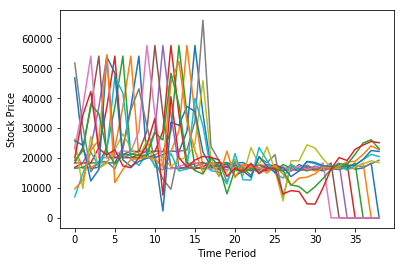

In [257]:
answer=LSTM(txs,7,'WeekNumber_Month_Season_Year' )

In [258]:
len(answer)

2

In [259]:
predict=answer[0]

In [260]:
real=answer[1]

In [261]:
predict[-1]

array([ 19292.24804688,  18450.27929688,  20468.671875  ,  22199.36523438,
        22779.8515625 ,  23070.11132812,  25120.765625  ], dtype=float32)

In [262]:
real[-1]

array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.])

In [263]:
rmse(predict[-1],real[-1])

21734.063210474265

In [264]:
list(predict[-1])

[19292.248, 18450.279, 20468.672, 22199.365, 22779.852, 23070.111, 25120.766]

In [234]:
denormalizedTestPredictY=[item for sublist in predict for item in sublist]

In [235]:
denormalizedTestPredictY

[25004.889,
 17878.67,
 18448.551,
 16625.063,
 23794.762,
 18926.037,
 22310.779,
 28988.189,
 16647.063,
 17655.199,
 15902.258,
 18758.281,
 21422.873,
 18815.676,
 27390.082,
 42252.961,
 13023.616,
 -17054.637,
 8713.7109,
 44013.387,
 28824.037,
 54875.152,
 9814.6406,
 6892.9678,
 34119.309,
 32063.373,
 17950.139,
 17710.721,
 46269.297,
 34165.398,
 26859.049,
 31506.697,
 40626.762,
 33309.164,
 32144.885,
 10130.913,
 19886.119,
 25303.898,
 12353.382,
 17963.152,
 22309.063,
 19594.828,
 20738.941,
 36639.18,
 13155.897,
 17237.949,
 1872.4343,
 7594.7642,
 22348.809,
 28669.564,
 59840.152,
 63524.957,
 33534.887,
 35908.84,
 25697.67,
 28739.646,
 49920.723,
 37315.395,
 24844.428,
 22487.34,
 31232.457,
 10106.243,
 17534.168,
 19177.609,
 15914.949,
 18269.627,
 15585.958,
 14997.678,
 13669.889,
 16800.967,
 17152.875,
 16120.986,
 12658.109,
 16700.432,
 11799.587,
 -2452.4717,
 13090.211,
 13131.864,
 -8086.0894,
 -10138.832,
 20595.971,
 29082.613,
 58904.629,
 1427

In [236]:
denormalizedTestY=originalSales[train_size+seq_length:]

NameError: name 'originalSales' is not defined

In [ ]:
# sales=noOutlierSales(sales)
tempxy=[list(txs['season']),list(txs['year']),list(txs['month']),list(txs['week_number']),sales]
# tempxy=[list(txs['season']),list(txs['day_of_week01']),list(txs['week_number']),sales]
xy=np.array(tempxy).transpose().astype(np.float)
originalxy=np.array(tempxy).transpose().astype(np.float)
xy=minMaxNormalizer(xy)

#data_dim은 y값 도출을 위한 feature 가지수+1(독립변수 가지수 +1(y포함))
data_dim=len(tempxy)
#data_dim크기의 data 한 묶음이 seq_length만큼 input으로 들어가
seq_length=5
#output_dim(=forecastDays)만큼의 다음날 y_data를 예측

output_dim=forecastDay
#hidden_dim은 정말 임의로 설정
hidden_dim=100
#learning rate은 배우는 속도(너무 크지도, 작지도 않게 설정)
learning_rate=0.01
#iterations는 반복 횟수
iterations=1000
x=xy
y=xy[:,[-1]]

#build a series dataset(seq_length에 해당하는 전날 X와 다음 forecastDays에 해당하는 Y)
dataX=[]
dataY=[]
for i in range(0, len(y)-seq_length - forecastDay):
    _x=x[i:i+seq_length]
    _y = y[i + seq_length:i + seq_length + forecastDay]
    _y = np.reshape(_y, (forecastDay))
#     print(_x,"->",_y)
    dataX.append(_x)
    dataY.append(_y)
    train_size = int(len(dataY) * 0.7)
    
test_size = len(dataY) - train_size
trainX, testX = np.array(dataX[0:train_size]), np.array(dataX[train_size:])
trainY, testY = np.array(dataY[0:train_size]), np.array(dataY[train_size:])
X=tf.placeholder(tf.float32, [None, seq_length, data_dim])
Y=tf.placeholder(tf.float32, [None, forecastDay])

cell = tf.contrib.rnn.BasicLSTMCell(num_units=hidden_dim, state_is_tuple=True, activation=tf.tanh)
outputs, _states = tf.nn.dynamic_rnn(cell, X, dtype=tf.float32)
Y_pred = tf.contrib.layers.fully_connected(outputs[:, -1], output_dim, activation_fn= None) 
loss = tf.reduce_sum(tf.square(Y_pred - Y))  # sum of the squares
optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(loss)
denormalizedTestY=originalSales[train_size+seq_length:]
# denormalizedTestY_original=sales[train_size+seq_length:]
denormalizedTestY_feed=np.array([[i] for i in denormalizedTestY])

targets = tf.placeholder(tf.float32, [None, 1])
predictions = tf.placeholder(tf.float32, [None, 1])
rmse = tf.sqrt(tf.reduce_mean(tf.square(targets - predictions)))
with tf.Session() as sess:
    #초기화
    init = tf.global_variables_initializer()
    sess.run(init)

    # Training step
    for i in range(iterations):
        _, step_loss = sess.run([train, loss], feed_dict={X: trainX, Y: trainY})
        print("[step: {}] loss: {}".format(i, step_loss))

    # Test step
    test_predict = minMaxDeNormalizer(sess.run(Y_pred, feed_dict={X: testX}),originalxy)

    # Plot predictions
    plt.plot(denormalizedTestY_feed) #실제 sales 파란색
    plt.plot(test_predict)           #예측 sales 주황색
    plt.xlabel("Time Period")
    plt.ylabel("Stock Price")
    plt.show()

In [ ]:
print(i for i in list(test_predict[-1]    ))

In [5]:
list(test_predict[  )

[17721.039]

In [6]:
denormalizedTestPredictY=[item for sublist in test_predict for item in sublist]

In [7]:
rootMeanSquaredError(denormalizedTestY,denormalizedTestPredictY)

IndexError: list index out of range

In [ ]:
len(denormalizedTestPredictY)

In [ ]:
denormalizedTestY